In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy
import numpy as np
import random
        
        
class BatchDataGenerator():
    
    def __init__(self, batch_parameters):
        self.batch_parameters = batch_parameters
        
    
    def read_data(self):
        
        def parse_data(filename):
            with open(filename, "rb") as f:
                infoline = f.readline()
                infoline = re.sub(r"^b'", "", str(infoline))
                n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
                features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
            mlb = MultiLabelBinarizer()
            labels = mlb.fit_transform(labels)
            features = np.array(features.todense())
            features = np.ascontiguousarray(features)
            return features, labels

        X, y = parse_data("Bibtex_data.txt")
        self.data = X
        self.labels = y
        self.data_length = len(X)
        
        
    def get_batch(self):

        curr = 0
        total_size = self.data_length
        DONE_FLAG = True

        while( curr < total_size ):
            start = curr
            end = (curr + self.batch_parameters['batch_size'])%total_size

            #print("Current ",start,end)
            if((end < start) and self.batch_parameters['WRAP_AROUND'] == True):
                size_to_end = total_size - curr
                size_leftover = self.batch_parameters['batch_size'] - size_to_end
                data_chunk_to_end = self.data[curr:]
                data_chunk_leftover = self.data[0:end]
                data_return = data_chunk_to_end + data_chunk_leftover
                labels_chunk_to_end = self.labels[curr:]
                labels_chunk_leftover = self.labels[curr:]
                labels_return = labels_chunk_to_end + labels_chunk_leftover
                yield(data_return, labels_return)
            elif((end < start) and (( self.batch_parameters['RUN_TILL_END_RESTART'] == True) or (self.batch_parameters['RUN_TILL_END_AND_STOP'] == True))):
                print("Getting to the end")
                DONE_FLAG = True
                yield(self.data[curr:], self.labels[curr:])
            else:
                yield(self.data[start: end], self.labels[start: end])


            if(self.batch_parameters['RUN_TILL_END_RESTART'] == True):
                    curr = (curr + self.batch_parameters['batch_size'])
                    if(curr > total_size):
                        curr = 0
            if(self.batch_parameters['RUN_TILL_END_AND_STOP'] == True):
                    curr = curr + self.batch_parameters['batch_size']
            if(batch_parameters['WRAP_AROUND'] == True):
                curr = (curr + self.batch_parameters['batch_size'])%total_size
                

                
class ContextualDeterministicEnv():
    
    ## Set class attributes such as context_dim and n_arms
    def __init__(self, context_dim_in, n_arms_in):
        self.context_dim = context_dim_in
        self.n_arms = n_arms_in
        self.reward = 1
      
    
    ## Generate a new context each time this method is called
    ## This is set as a state here in this class
    ## number of actions is the number of arms
    def get_context(self) -> np.ndarray:
        self.current_context = random.randint(0, self.n_arms-1)
        return np.array([self.current_context]).reshape(1, 1)
        #return(self.current_context)
    
    
    ## Set the logic for the correct action for a context
    ## Dictionary {(0,0): 0, (0,1): 2, (1,0): 3, (1,1): 4 }
    def set_context_action_mapping(self, context_action_mapping) -> None:
        self.context_action_mapping = context_action_mapping
        
        
    ## Given an action get the reward for that action for the current context
    ## Convert numpy array to tuple as tuple(map(tuple, arr))
    def get_reward(self, action: int, context: np.ndarray) -> float:
        if(self.context_action_mapping[str(context)] == action):
            return self.reward
        else:
            return 0

        
    def get_num_arms(self) -> int:
        return self.n_arms

    
    def get_context_dim(self) -> int:
        return self.context_dim

In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from contextualbandits.linreg import LinearRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, LinUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

# batch size - algorithms will be refit after N rounds
batch_size = 50

batch_parameters = {'batch_size': batch_size, 'RUN_TILL_END_AND_STOP': True, 'RUN_TILL_END_RESTART':False, 'WRAP_AROUND': False}
data_obj = BatchDataGenerator(batch_parameters)
data_obj.read_data()
data_iter = data_obj.get_batch()
data = next(data_iter)

nchoices = data[1].shape[1]

base_sgd = SGDClassifier(random_state=123, loss='log', warm_start=False)
base_ols = LinearRegression(lambda_=10., fit_intercept=True, method="sm")

## Metaheuristic using different base algorithms and configurations
linucb = LinUCB(nchoices = nchoices, beta_prior = None, alpha = 0.1,
                ucb_from_empty = False, random_state = 1111)
### Important!!! the default hyperparameters for LinUCB in the reference paper
### are very different from what's used in this example
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                        smoothing = None, beta_prior = ((3./nchoices,4.), 2),
                                        active_choice = 'weighted', decay_type = 'percentile',
                                        decay = 0.9997, batch_train = True,
                                        random_state = 2222)
softmax_explorer = SoftmaxExplorer(deepcopy(base_sgd), nchoices = nchoices,
                                   smoothing = (1,2), beta_prior = None, batch_train = True,
                                   refit_buffer = 50, deep_copy_buffer = False, random_state = 3333)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                      smoothing = (1,2), beta_prior = None,
                                      decay_type = 'percentile', decay = 0.9997, batch_train = True,
                                      random_state = 4444)
active_explorer = ActiveExplorer(deepcopy(base_sgd), smoothing = None, nchoices = nchoices,
                                 beta_prior = ((3./nchoices, 4.), 2), batch_train = True, refit_buffer = 50,
                                 deep_copy_buffer = False, random_state = 5555)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_ols), nchoices = nchoices,
                                       smoothing = (1,2), beta_prior = None,
                                       decay = None, batch_train = True,
                                       deep_copy_buffer = False, random_state = 6666)


models = [linucb, adaptive_active_greedy, softmax_explorer, adaptive_greedy_perc,
          active_explorer, epsilon_greedy_nodecay]

In [3]:
# These lists will keep track of the rewards obtained by each policy
rewards_lucb, rewards_aac, rewards_sft, rewards_agr, \
rewards_ac, rewards_egr = [list() for i in range(len(models))]

lst_rewards = [rewards_lucb, rewards_aac, rewards_sft,
               rewards_agr, rewards_ac, rewards_egr]

X_total = np.empty((0, data[0].shape[1]), float)
y_total = np.empty((0, data[1].shape[1]), float)

# initial seed - all policies start with the same small random selection of actions/rewards
batch_parameters = {'batch_size': batch_size, 'RUN_TILL_END_AND_STOP': True, 'RUN_TILL_END_RESTART':False, 'WRAP_AROUND': False}
data_obj = BatchDataGenerator(batch_parameters)
data_obj.read_data()
data_iter = data_obj.get_batch()
data = next(data_iter)

first_batch, y_batch = data
print(first_batch.shape)
print(y_batch.shape)
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = np.array([elem[action] for elem,action in zip(y_batch, action_chosen)])
print(rewards_received)
print(action_chosen.shape)
print(rewards_received.shape)

X_total = np.vstack([X_total, first_batch])
y_total = np.vstack([y_total, y_batch])

print(first_batch.shape, action_chosen.shape, rewards_received.shape)
# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

(50, 1836)
(50, 159)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
(50,)
(50,)
(50, 1836) (50,) (50,)


/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and 

/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/srajamohan/miniconda3/envs/bandits_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and 

In [4]:
# these lists will keep track of which actions does each policy choose
lst_a_lucb, lst_a_aac, lst_a_sft, lst_a_agr, \
lst_a_ac, lst_a_egr = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_lucb, lst_a_aac, lst_a_sft,
               lst_a_agr, lst_a_ac, lst_a_egr]


## rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_batch, y_batch ):
    np.random.seed(1)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')

    #print("Actions ", actions_this_batch)
    
    ## adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    
    ## keeping track of the sum of rewards received
    current_selected_rewards = np.array([elem[action] for elem, action in zip(y_batch, actions_this_batch)])
    rewards.append(current_selected_rewards.sum())
    
    print("New actions hist ",sum(new_actions_hist), len(new_actions_hist), sum(rewards))
    
    model.partial_fit(X_batch, actions_this_batch, current_selected_rewards)
    
    return new_actions_hist


ct = 0
# now running all the simulation
for elem in iter(data_iter):
    ct += 1
    print(ct)
    X_batch, y_batch = elem
    X_total = np.vstack([X_total, X_batch])
    y_total = np.vstack([y_total, y_batch])
    
    for model in range(len(models[2:4])):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X_batch, y_batch)
        
        
        

1
New actions hist  6121 100 1
New actions hist  8990 100 1
2
New actions hist  13971 150 1
New actions hist  13073 150 1
3
New actions hist  19022 200 2
New actions hist  16935 200 1
4
New actions hist  25122 250 2
New actions hist  21258 250 1
5
New actions hist  29518 300 3
New actions hist  24990 300 2
6
New actions hist  30744 350 4
New actions hist  29454 350 4
7
New actions hist  34972 400 5
New actions hist  34354 400 10
8
New actions hist  38814 450 6
New actions hist  39043 450 22
9
New actions hist  42074 500 8
New actions hist  43186 500 31
10
New actions hist  44991 550 9
New actions hist  47140 550 43
11
New actions hist  48978 600 11
New actions hist  51454 600 52
12
New actions hist  54313 650 13
New actions hist  55409 650 57
13
New actions hist  58685 700 14
New actions hist  59414 700 65
14
New actions hist  63416 750 17
New actions hist  64031 750 71
15
New actions hist  67819 800 21
New actions hist  68582 800 80
16
New actions hist  70965 850 23
New actions hist  

New actions hist  493709 5950 1371
New actions hist  449193 5950 1421
119
New actions hist  497570 6000 1386
New actions hist  453078 6000 1435
120
New actions hist  501182 6050 1406
New actions hist  457038 6050 1452
121
New actions hist  504744 6100 1432
New actions hist  460871 6100 1465
122
New actions hist  508772 6150 1454
New actions hist  464557 6150 1483
123
New actions hist  512582 6200 1472
New actions hist  467962 6200 1499
124
New actions hist  517133 6250 1489
New actions hist  472315 6250 1517
125
New actions hist  520862 6300 1507
New actions hist  476780 6300 1530
126
New actions hist  524785 6350 1525
New actions hist  480594 6350 1544
127
New actions hist  529204 6400 1545
New actions hist  484925 6400 1558
128
New actions hist  533584 6450 1568
New actions hist  489236 6450 1577
129
New actions hist  537896 6500 1588
New actions hist  493263 6500 1592
130
New actions hist  542174 6550 1611
New actions hist  497734 6550 1612
131
New actions hist  546319 6600 1630
New

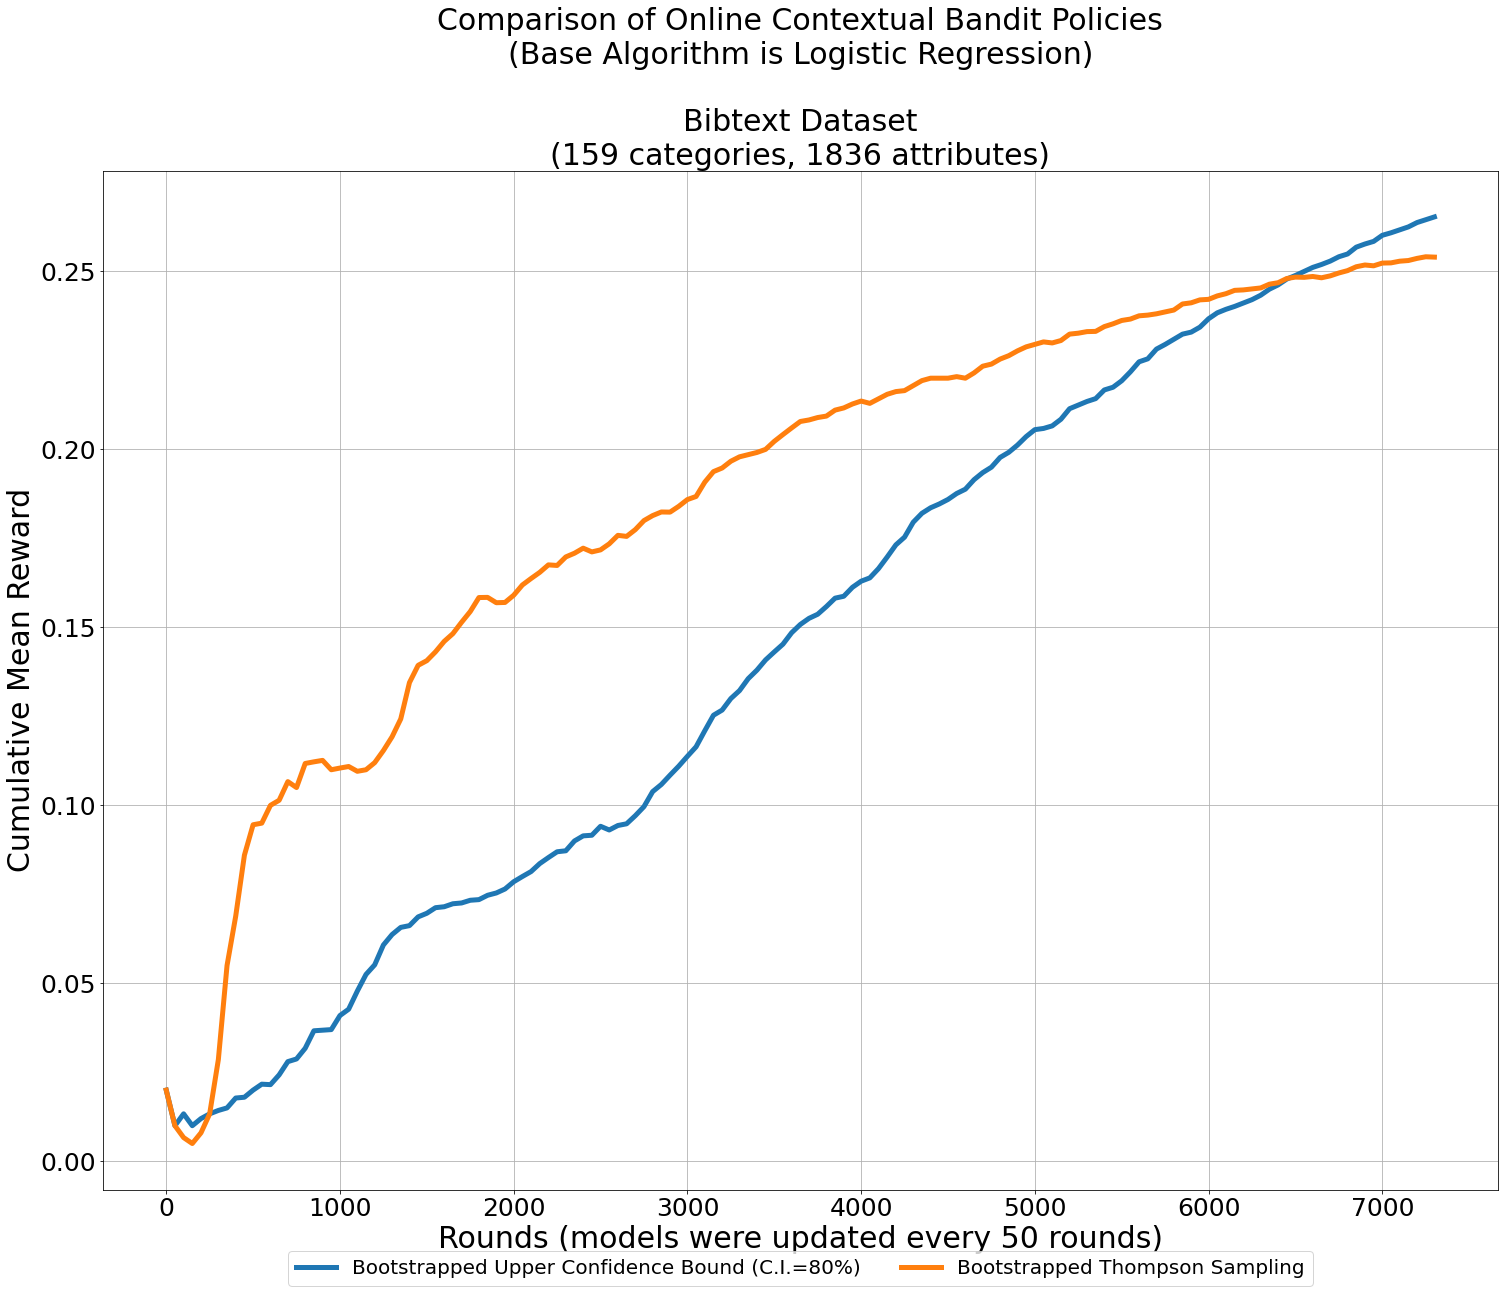

In [5]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_lucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_aac), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])

# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [6]:
a,b,c,d = [list() for i in range(4)] 

In [7]:
lst_rewards = [a,b,c,d]

In [8]:
import numpy as np
action_chosen = np.random.randint(3, size=4)
action_chosen

array([1, 0, 0, 1])

In [9]:
[action_chosen.copy() for i in range(4)]

[array([1, 0, 0, 1]),
 array([1, 0, 0, 1]),
 array([1, 0, 0, 1]),
 array([1, 0, 0, 1])]